In [1]:
# Check basic SPI interface connection
import spidev

spi = spidev.SpiDev()
spi.open(0,0)

In [10]:
# Let's define a way to receive a single sound input
def getSingleAdc(channel):
    # check for valid channel
    if ((channel > 7) or (channel < 0)):
        return -1

    # Preform SPI transaction and store returned bits in 'r'
    r = spi.xfer([1, (8 + channel) << 4, 0])

    adcOut = ( (r[1] & 3) << 8 ) + r[2]
    return adcOut
    
def getMultiAdc(channel, sampleSize):
    if ((channel > 7) or channel < 0):
        return -1
    
    resultArray = []
    for _ in range(sampleSize):
        r = spi.xfer2([1, (8+channel) << 4, 0])
        resultArray.append(( (r[1] & 3) << 8 ) + r[2])
    
    return resultArray

In [11]:
# Let's do a little timing test for 10000 input readings
import time

# Let's repeat the same experiment several times
for i in range(5):
    start = time.time()
    for _ in range(10000):
        getSingleAdc(0)
    print "Single method took {} seconds for 10k readings".format(time.time() - start)

    start = time.time()
    getMultiAdc(0, 10000)
    print "Multi method took {} seconds for 10k readings".format(time.time() - start)
    print "-------RUN {}-------\n".format(i)

Single method took 1.21672511101 seconds for 10k readings
Multi method took 1.23376202583 seconds for 10k readings
-------RUN 0-------

Single method took 1.47023081779 seconds for 10k readings
Multi method took 1.59227204323 seconds for 10k readings
-------RUN 1-------

Single method took 1.62337398529 seconds for 10k readings
Multi method took 1.59170985222 seconds for 10k readings
-------RUN 2-------

Single method took 1.61836504936 seconds for 10k readings
Multi method took 1.59092903137 seconds for 10k readings
-------RUN 3-------

Single method took 1.61239504814 seconds for 10k readings
Multi method took 1.592897892 seconds for 10k readings
-------RUN 4-------



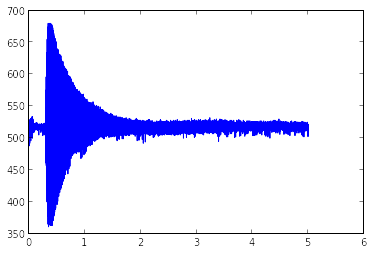

In [51]:
# MAke sure we can see matplotlib graphs
%matplotlib inline

# Looks like both methods are approximately the same - on to plotting the output and understanding interval
import numpy as np
import matplotlib.pyplot as plt
import scipy

x = []
y = []

start = time.time() # Start at the current time
while True: # We're just going to collect samples for 5 seconds - in this case an A note (~440 Hz)
    y.append(getSingleAdc(0))
    x.append(time.time() - start)
    if time.time() >= (start+5):
        break

plt.plot(x, y)

Total data points for 5 seconds: 38455
440Hz => 440 cycles per second, so 1 cycle = 1.0 / 440 seconds = 0.00227272727273
Going to use a sample sapce of 2048 - need to calculate the approx sample frequency: 7635.79605958


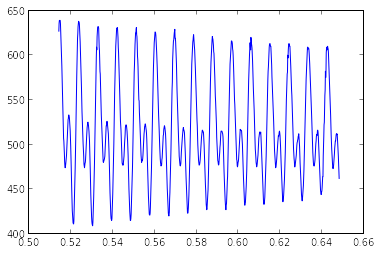

In [81]:
# Let's try and zoom in on a small section of the large plot above so we can view the actual waves
x_length = len(x)
start = (x_length / 10)

sample_length = 1024

print("Total data points for 5 seconds: {}".format(len(x)))

print("440Hz => 440 cycles per second, so 1 cycle = 1.0 / 440 seconds = {}".format(1.0 / 440))

print("Going to use a sample sapce of 2048 - need to calculate the approx sample frequency: {}". \
      format(sample_length / (x[start+sample_length] - x[start])))

plt.plot(x[start:start+sample_length], y[start:start+sample_length])

In [82]:
# Let's use the data as above for the graph to play with
x_data = np.array(x[start:start+sample_length])
y_data = np.array(y[start:start+sample_length])
avg_sample_rate = sample_length / float(x[start+sample_length] - x[start])

# Let's normalize the y data - 
y_normalized_data = y_data / 1024.0 # MCP3008 uses 10-bit numbers so max is 1024

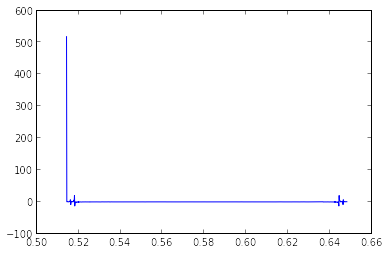

In [83]:
y_fft = scipy.fft(y_normalized_data)

plt.plot(x_data, y_fft)

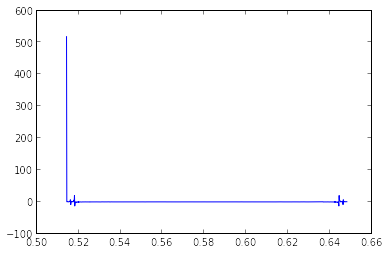

In [84]:
x_new = np.arange(1024)
plt.plot(x_data, y_fft)

[ 41.46351563   0.05588813   0.06502562 ...,   0.05499956   0.06500447
   0.05588207]
Which: 0
And the Frequency is: 309.186473853


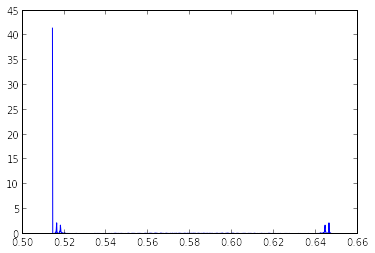

In [85]:
from scipy.signal import hamming, convolve

w = hamming(sample_length)
intensity = abs(w*y_fft)

plt.plot(x_data, intensity)
print(intensity)
which = intensity.argmax()[1:].argmax + 1

print("Which: {}".format(which))

y0,y1,y2 = np.log(intensity[which-1:which+2:])
x1 = (y2 - y0) * .5 / (2 * y1 - y2 - y0)
thefreq = (which+x1)*avg_sample_rate/sample_length
adjfreq = 1
print("The frequency is: {}".format(thefreq))

freq = intensity[which] * avg_sample_rate / sample_length
print("And the Frequency is: {}".format(freq))

In [86]:
new_adjfreq = 1200 *np.log2(440/float(freq))/100
newer_adjfreq = new_adjfreq % 12
print("Cents: {}".format(newer_adjfreq))

Cents: 6.10831580954
